# Examining Seattle Das-train_noise

In [15]:
import h5py
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np
import datetime
import pandas as pd
from dasquakes import *
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from libcomcat.search import search
from libcomcat.dataframes import get_summary_data_frame
import matplotlib.dates as mdates

### Load the DAS Data

In [18]:
 cable = 'seadasn'
#cable = 'whidbey'
#cambiar la carpeta para encontrar los datos de noviembre.
#definir los channels
record_length = 5 #minutes

 t0 = datetime.datetime(2022, 5, 19, 1, 57, 0)
#t0 = datetime.datetime(2022, 11, 7, 1, 0, 0)


prefix, network_name, datastore = data_wrangler(cable,record_length,t0)
data,dates,attrs = open_sintela_file(prefix,
                                     t0,
                                     datastore,
                                     number_of_files=record_length,
                                     verbose=True)
dx = attrs['SpatialSamplingInterval']
x_max=data.shape[1] * dx

/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-05-19_01-57*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-05-19_01-58*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-05-19_01-59*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-05-19_02-00*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-05-19_02-01*.h5


In [8]:
date_format = mdates.DateFormatter('%H:%M:%S')
x_lims = mdates.date2num(dates)

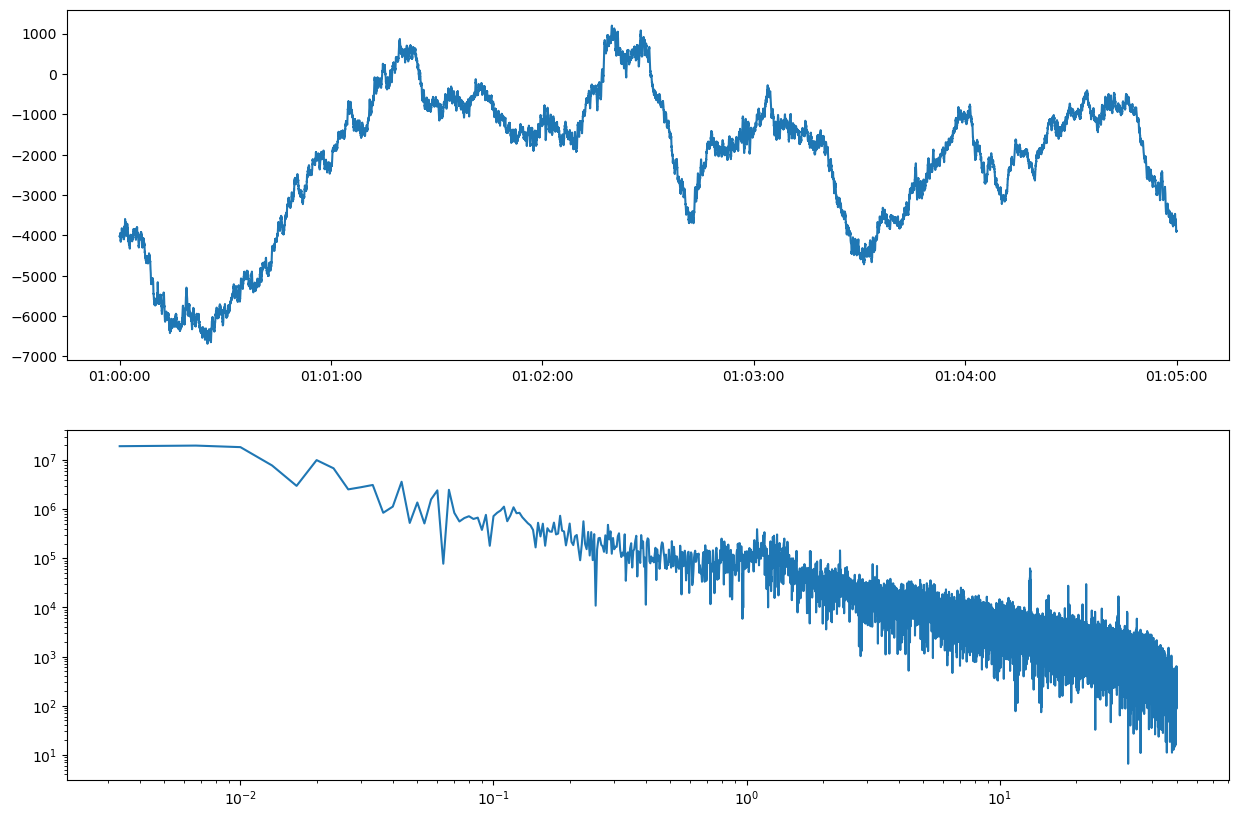

In [9]:
from scipy.signal import detrend
from numpy.fft import fft,fft2,fftfreq,fftshift

fig,ax=plt.subplots(2,1,figsize=(15,10))
ax=plt.subplot(211)
plt.plot(x_lims,np.sum(data,axis=1))
ax.xaxis.set_major_formatter(date_format)
ax.xaxis_date()

plt.subplot(212)
f = fftfreq(data.shape[0],0.01)
ft = np.abs(fft(np.sum(data,axis=1)))
plt.loglog(f[f>0],ft[f>0])

In [ ]:
def plot_filtered_data(low_cut,hi_cut,das_vmax=0.1):
    b,a = butter(2,(low_cut,hi_cut),'bp',fs=attrs['MaximumFrequency']*2)
    # data_filt = filtfilt(b,a,data[:,1200:1650],axis=0)
    data_filt = filtfilt(b,a,data,axis=0)

    fig,ax=plt.subplots(figsize=(12,12))


    # Subplot: DAS Data

    plt.imshow(data_filt.T,vmin=-das_vmax,vmax=das_vmax,
               cmap='seismic',aspect='auto', 
               extent=[x_lims[0],x_lims[-1],0,x_max])
    ax.xaxis.set_major_formatter(date_format)
    ax.xaxis_date()
    # plt.ylim([0, 4000])
    plt.grid()
    plt.title(f'Filter {low_cut}-{hi_cut} Hz')
    plt.show()
    
plot_filtered_data(1,8)
plot_filtered_data(0.2,1,das_vmax=1)
plot_filtered_data(0.05,0.2,das_vmax=1)

In [ ]:
# Entire subsea region:
# x1 = 1225
# x2 = 1600

# Whidbey half of subsea region:
# x1 = 1225
# x2 = 1412

# Camano half of subsea region:
x1 = 1412
x2 = 1600

xmax = 1720

subsea_data = detrend(data[:,x1:x2])

ft = fftshift(fft2(subsea_data))
f = fftshift(fftfreq(subsea_data.shape[0], d=0.01))
k = fftshift(fftfreq(subsea_data.shape[1], d=attrs['SpatialSamplingInterval']))

In [ ]:
plt.subplots(1,2,figsize=(15,8))
das_vmax=1


low_cut = 0.2
hi_cut = 2

b,a = butter(2,(low_cut,hi_cut),'bp',fs=attrs['MaximumFrequency']*2)
subsea_data_filt = filtfilt(b,a,subsea_data,axis=0)


ax=plt.subplot(121)
ax.imshow(subsea_data_filt.T,vmin=-das_vmax,vmax=das_vmax,
           cmap='seismic',aspect='auto', 
           extent=[x_lims[0],x_lims[-1],(xmax-x2)*dx,(xmax-x1)*dx])
ax.xaxis.set_major_formatter(date_format)
ax.xaxis_date()
ax.set_xlim(x_lims[5000],x_lims[15000])
for i, tick in enumerate(ax.xaxis.get_ticklabels()):
    if i % 2 != 0:
        tick.set_visible(False)
        
ax.set_ylabel('Distance (m)',fontsize=18)
ax.set_xlabel('Time (HH:MM:SS)',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


        
ax=plt.subplot(122)
c = ax.imshow(np.log10(np.abs(ft)),
               aspect='auto',cmap='Greys',
               vmin=3,vmax=6,
               extent=[k[0],k[-1],f[0],f[-1]])

# omega = np.sqrt(g*k * np.tanh(k*h))
# plt.plot(k,omega)

# kappa = np.sqrt(1 + np.tan(45 * np.pi/180)**2 ) * k
# omega = np.sqrt(g*kappa * np.tanh(kappa*h))
# plt.plot(k,omega)

# kappa = np.sqrt(k**2 + 0.01**2)
# omega = np.sqrt(g*kappa * np.tanh(kappa*h))
# plt.plot(k,omega)


ax.set_ylabel('Frequency (Hz)',fontsize=18)
ax.set_xlabel('Wavenumber (1/m)',fontsize=18)
ax.set_ylim([-2.5,2.5])
# ax.legend()
# plt.ylim([0])
ax.set_xlim([-0.04,0.04])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.colorbar(c)
plt.grid()
plt.show()